In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [15]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [2]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [3]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [16]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [4]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

In [4]:
tpath = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/20051001_20060501.pkl'
with open(tpath, 'rb') as f:
    tracks_obj = pickle.load(f)

In [5]:
tracks_obj.params

{'SEARCH_MARGIN': 50000,
 'FLOW_MARGIN': 40000,
 'MAX_FLOW_MAG': 60,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 60,
 'MAX_SHIFT_DISP_ALT': 25,
 'ISO_SMOOTH': 3,
 'GS_ALT': 2000,
 'LEVELS': array([[  500,  2500],
        [ 2500,  7500],
        [ 7500, 10000]]),
 'MIN_SIZE': [80, 400, 800],
 'FIELD_THRESH': ['convective', 20, 15],
 'ISO_THRESH': [10, 10, 10],
 'TRACK_INTERVAL': 0,
 'CELL_THRESH': 25,
 'CELL_START': 3000,
 'RAIN': False,
 'SAVE_RAIN': False,
 'AMBIENT': 'ERA5',
 'AMBIENT_BASE_DIR': '/g/data/w40/esh563/era5/pressure-levels/reanalysis/',
 'DT': 10,
 'CLASS_THRESH': {'OFFSET_MAG': 10000,
  'SHEAR_MAG': 2,
  'VEL_MAG': 5,
  'REL_VEL_MAG': 2,
  'ANGLE_BUFFER': 10},
 'EXCL_THRESH': {'SMALL_AREA': 500,
  'LARGE_AREA': 50000,
  'BORD_THRESH': 0.001,
  'MAJOR_AXIS_LENGTH': 100,
  'AXIS_RATIO': 3,
  'DURATION': 30},
 'BOUNDARY_GRID_CELLS': {(0, 48),
  (0, 49),
  (0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58),
  (0, 59),
  (0, 60),
  

In [83]:
exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']
excluded = tracks_obj.exclusions[exclusions]
amb = 'Ambiguous (On Quadrant Boundary)'
quad_bound = tracks_obj.tracks_class['offset_type'] == amb
excluded = np.logical_or(np.any(excluded, 1), quad_bound)
included = np.logical_not(excluded)

In [84]:
u_shear = tracks_obj.tracks['u_shear'].where(included==True).dropna().xs(0, level='level')
v_shear = tracks_obj.tracks['v_shear'].where(included==True).dropna().xs(0, level='level')

shear_angle = np.arctan2(v_shear, u_shear)
shear_angle = np.rad2deg(shear_angle)

orientation = tracks_obj.tracks['orientation'].where(included==True).dropna().xs(0, level='level')

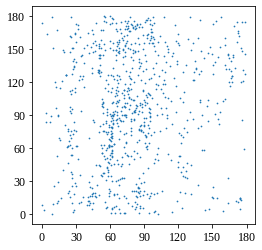

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.sca(ax)
plt.xticks(np.arange(0,180+30,30))
plt.yticks(np.arange(0,180+30,30))
ax.scatter(
    np.mod(shear_angle + 90, 180), np.mod(orientation, 180), 
    marker='.', s=2)